# This tutorial generates a simulated data and use EBtimecourse to find change points in the data.

In [1]:
rm(list=ls())
setwd("~/Documents/Research/Microarray_time_course/manuscript/EBtimecourse")
library(tensorflow)
use_python("/usr/local/bin/python3")
source("EBtimecourse.R")

Use Normal Normal-Gamma model to generate a data matrix of 1000 genes by 8 time points, and numbers of replicates for the 8 time points are 3, 3, 3, 4, 2, 3, 3 respectively, so total columns are 24. In this simulation, we set P=0.2, which means 20% genes having change points and these genes are put in the top 20% rows of the data matrix. In the parameter matrix, it stores parameters to generate data. In the parameter matrix, mu1 and mu2 stand for the latent means, sigma1 and sigma2 stand for variances. n1, n2 and n3 stand for the length of the three homogeneous sequences, for example, if n1=2, n2=1, n3=5, it means the two change points are after 2nd and 3rd time point.

In [2]:
set.seed(0)

P=0.2 # proportion of genes to have change points
N=1000;

nDE=P*N; nEE=N-nDE;
cp_real_seq_index=1:nDE;
timePoint=8; # number of time points
replicate=c(3,3,3,4,2,3,3,3); # number of replicated of each time points, for example, this vector means 4th time point has 4 replicates and 5th time point has 2 replicates, the others have 3 replicates
Ti=sum(replicate); 

changePointTable = data.frame(matrix(NA, nrow=(timePoint-1)+(timePoint-1)*(timePoint-2)/2, ncol=3), stringsAsFactors=F)
colnames(changePointTable) = c("n1", "n2", "n3")
changePointTable[1:(timePoint-1),"n1"]=1:(timePoint-1)
changePointTable[1:(timePoint-1),"n2"]=(timePoint-1):1
changePointTable[1:(timePoint-1),"n3"]=0
combT = as.data.frame(t(combn(timePoint-1, 2)))
combT$V2 = combT$V2 - combT$V1
changePointTable[timePoint:nrow(changePointTable),c("n1","n2")]=combT
changePointTable[timePoint:nrow(changePointTable),"n3"]=timePoint-rowSums(changePointTable[timePoint:nrow(changePointTable),c("n1", "n2")])
combNumber = nrow(changePointTable)

ss=sample(1:nrow(changePointTable), P*N, replace=T)
n1=changePointTable[ss,"n1"]
n2=changePointTable[ss,"n2"]
n3=changePointTable[ss,"n3"]

n1=c(n1, rep(timePoint,nEE)); n2=c(n2, rep(0, nEE)); n3=c(n3, rep(0, nEE));
mu0=0; kappa0=0.1; alpha0=1; beta0=10;
lambda = rgamma(N*2, shape=alpha0, rate=beta0)
mu = rnorm(N*2,mean=mu0,sd=1/sqrt(kappa0*lambda))
lambda = matrix(lambda, ncol=2)
mu = matrix(mu, ncol=2)
sigma = 1/sqrt(lambda)
parameter=data.frame(mu, sigma, n1=n1, n2=n2, n3=n3)
colnames(parameter)=c("mu1", "mu2", "sigma1", "sigma2", "n1", "n2", "n3")

gene.de=t(apply(parameter[1:nDE,],1, function(x) 
  c(rnorm(sum(replicate[1:x[5]]), mean=x[1], sd=x[3]), rnorm(sum(replicate[(x[5]+1):(x[5]+x[6])]), mean=x[2], sd=x[4]),
    rnorm(sum(replicate[-c(1:(x[5]+x[6]))]), mean=x[1], sd=x[3]))))
gene.ee=t(apply(parameter[(nDE+1):N,],1, function(x) c(rnorm(Ti, mean=x[1], sd=x[3]))))

gene.exp=rbind(gene.de, gene.ee)
                
dim(gene.exp)
head(gene.exp)
head(parameter)

[1] 1000   24

1,-2.578914,-5.008225,3.883200,-5.900468,-3.035626,-1.901751,-9.531408,20.1844812,0.01100666,-10.559859,⋯,-5.397981,-4.951023,-9.2426663,-0.7181269,-10.601577,-1.298571,-0.8839284,-2.587046,-6.018523,0.6024899
2,-5.789879,-3.571147,-7.502044,-3.457898,-6.023532,-6.615295,-4.051317,-4.3336006,-6.16983272,-8.977959,⋯,-6.991738,-9.431366,-6.1973077,-12.3601702,-6.640681,-13.833225,-9.8541556,-3.856033,-3.630031,-4.2155801
3,-4.632496,-13.537417,-15.071868,-21.705240,-16.063009,-2.344622,-15.015141,2.7187531,-26.34601794,-14.912734,⋯,-18.370618,-18.444200,-10.0784418,-30.3183154,-15.474552,-19.635260,-11.0438885,-27.191105,-23.837181,-20.6881641
4,-18.896538,-29.197519,-23.401813,-22.985557,-27.997242,-26.352140,-26.357198,-24.6143701,-21.85819628,-29.893234,⋯,-33.281545,-26.938101,-23.1363410,-25.0826744,-25.214864,-26.290240,-33.0118526,19.929165,35.736492,15.9762683
5,1.166935,-0.998462,3.931977,5.562003,2.250273,-10.031706,7.537726,-0.2054674,-0.62268390,8.242396,⋯,-1.782336,-3.143083,0.6042293,6.4091607,2.073749,-1.671993,-0.1972193,1.783717,-14.122523,-5.0991716
6,4.441938,4.944880,3.510511,4.086975,1.578461,4.511351,-10.394249,-9.2051410,-9.64401096,-7.358380,⋯,-6.771395,-5.443706,-7.3510250,-7.6224540,-9.564551,-6.633108,-7.1588060,-6.772567,-8.247895,-13.1447463


,mu1,mu2,sigma1,sigma2,n1,n2,n3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-4.136114,19.657980,3.516770,14.896818,2,1,5
2,-6.020321,-7.394323,2.042558,2.319634,4,3,1
3,-12.229347,-22.233660,8.124266,7.104597,4,4,0
4,-24.981949,20.903863,4.393284,7.633993,7,1,0
5,-1.578031,-0.970269,4.386907,4.936935,1,7,0
6,3.679111,-6.892291,1.526077,2.502622,2,6,0


Run EBtimecourse

In [3]:
ptm <- proc.time()
result = EBtimecourse(exp.dat = gene.exp, timepoint = timePoint, replicate = replicate, FDR=0.1, verbose=F)
print(proc.time() - ptm)

20766 74654.9519934905

Max delta ll: 4.36557456851006e-11



[1] "Converge params:"
$P
[1] 0.8042199

$mu0
[1] -0.2296202

$kappa0
[1] 0.100948

$alpha0
[1] 0.9621092

$beta0
[1] 9.723614

   user  system elapsed 
249.929  61.779  92.102 


Summarize the sensitivity and FDR for Q1 and Q2

In [4]:
Q1_sensitivity = sum(result$cp.index %in% cp_real_seq_index)/nDE
Q1_FDR = sum(!(result$cp.index %in% cp_real_seq_index))/length(result$cp.index)
cp_position_correct_numer = 0
cp_position_not_correct_numer = 0
for(i in 1:nrow(result$cp.position)) {
  if(parameter[result$cp.position$SeqID[i],"n1"]==result$cp.position[i, "n1"] & parameter[result$cp.position$SeqID[i],"n2"]==result$cp.position[i, "n2"])
    cp_position_correct_numer=cp_position_correct_numer+1
  else
    cp_position_not_correct_numer = cp_position_not_correct_numer+1
}
Q2_sensitivity=cp_position_correct_numer/nDE
Q2_FDR=cp_position_not_correct_numer/nrow(result$cp.position)

print(Q1_sensitivity)
print(Q1_FDR)
print(Q2_sensitivity)
print(Q2_FDR)

[1] 0.795
[1] 0.0755814
[1] 0.725
[1] 0.07643312


Plot heatmaps of different change-point patterns

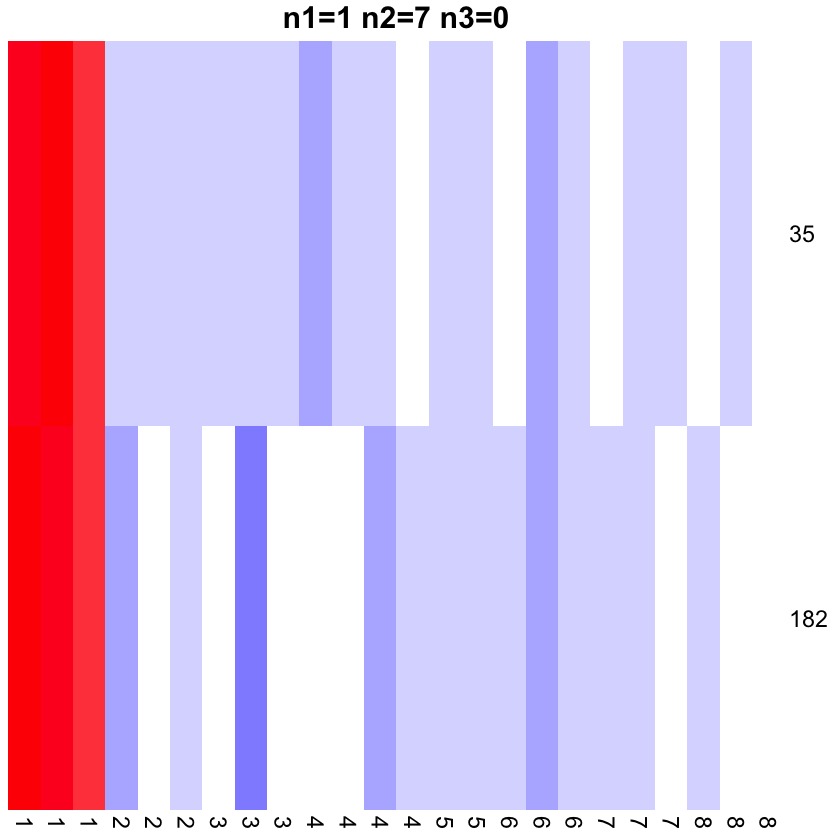

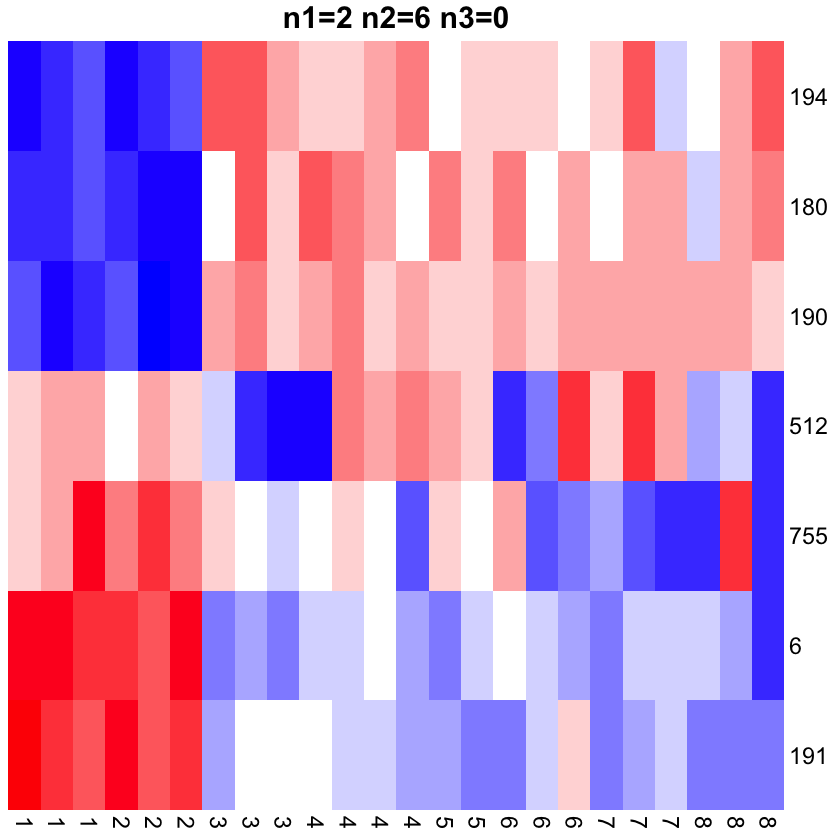

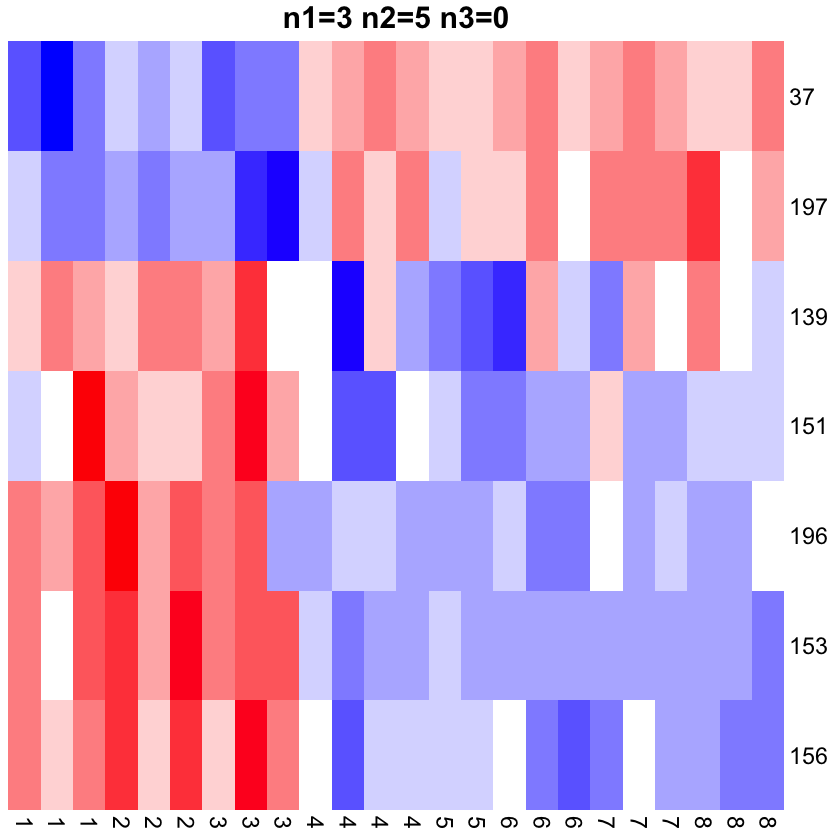

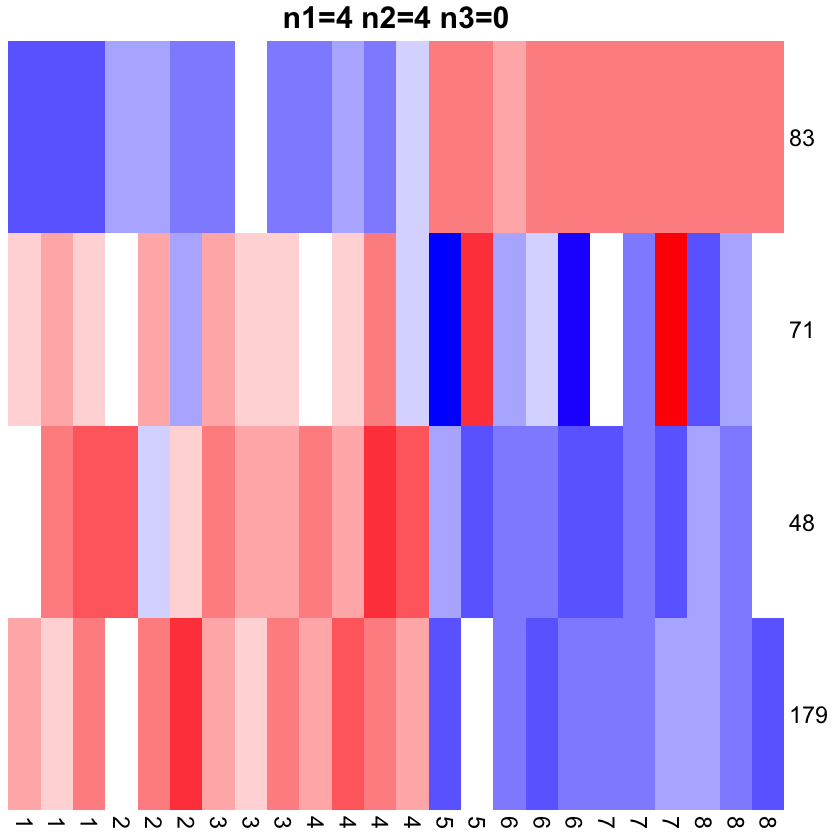

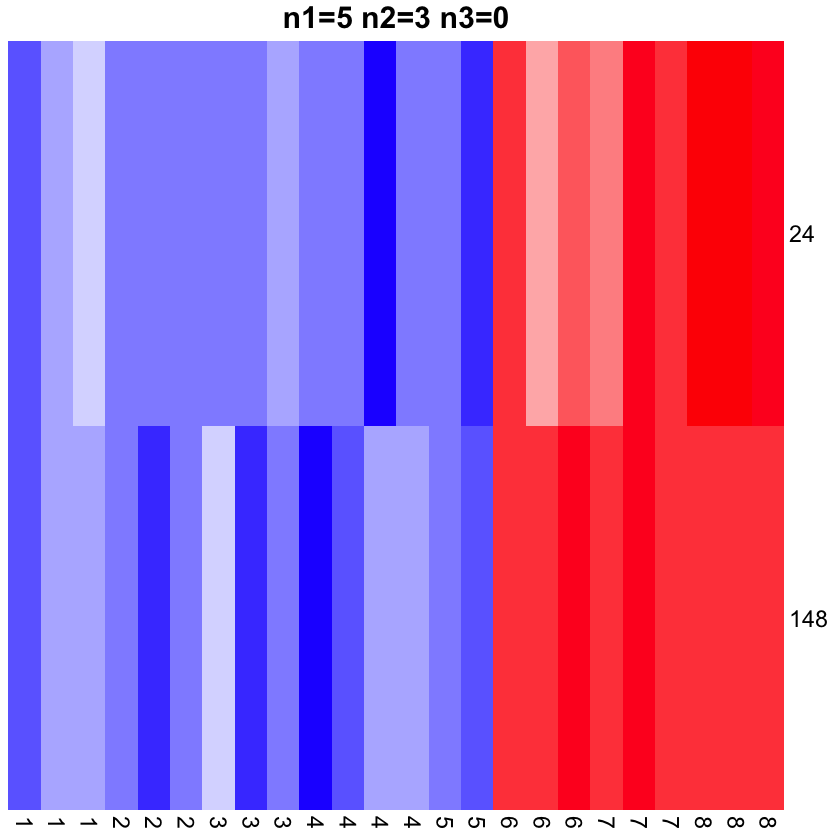

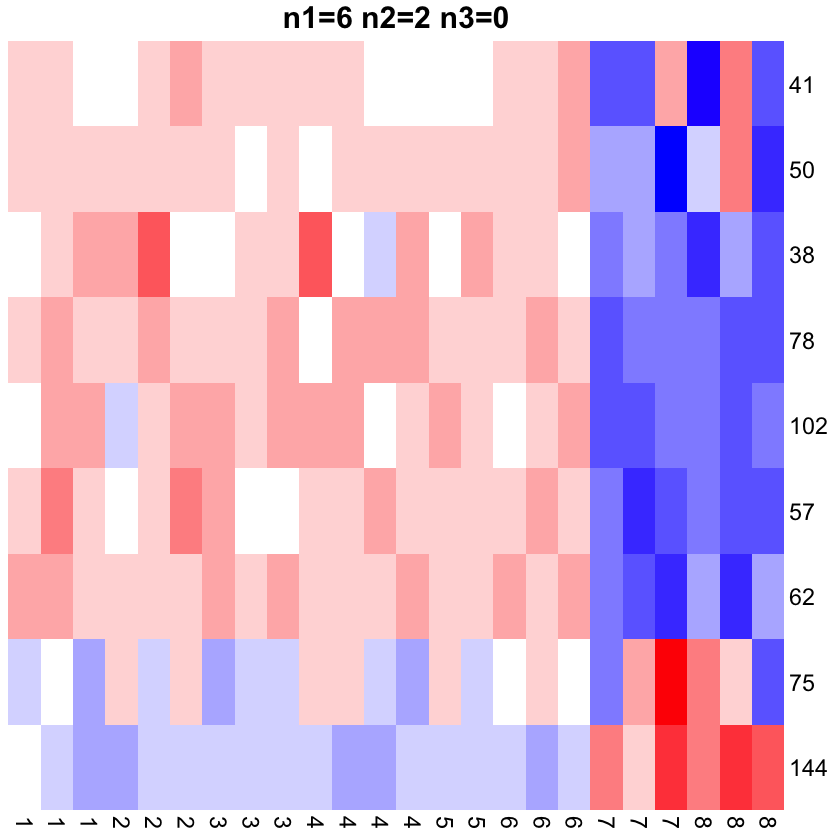

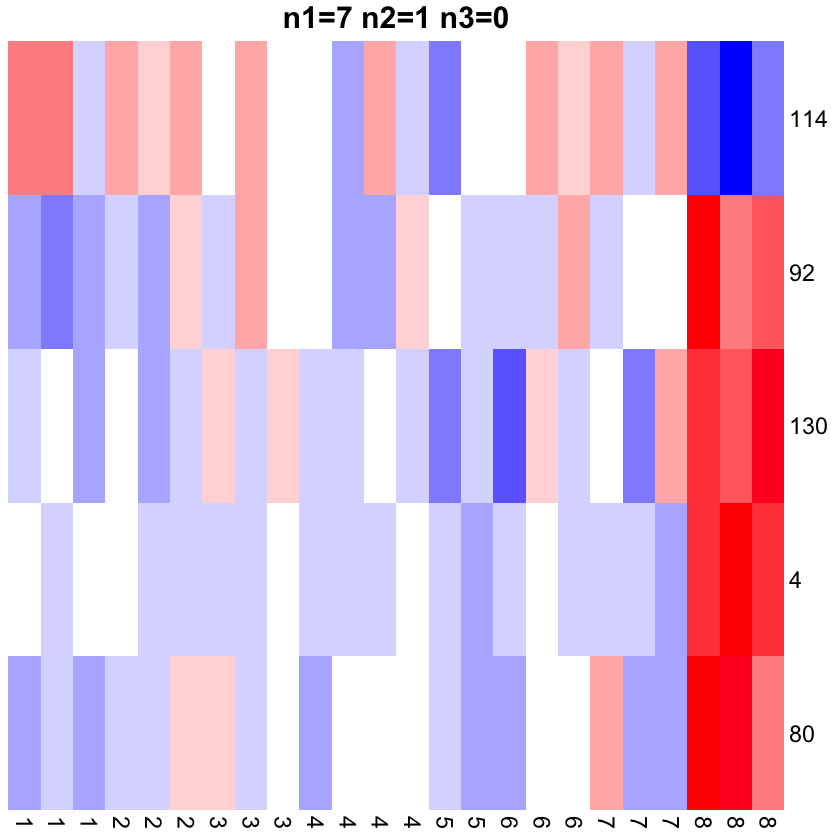

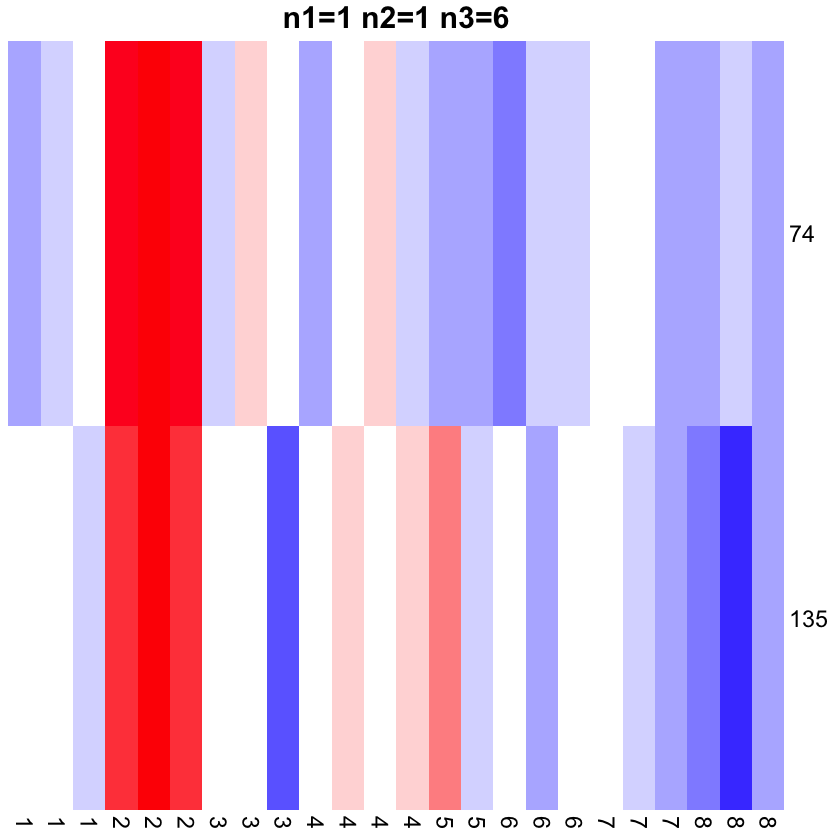

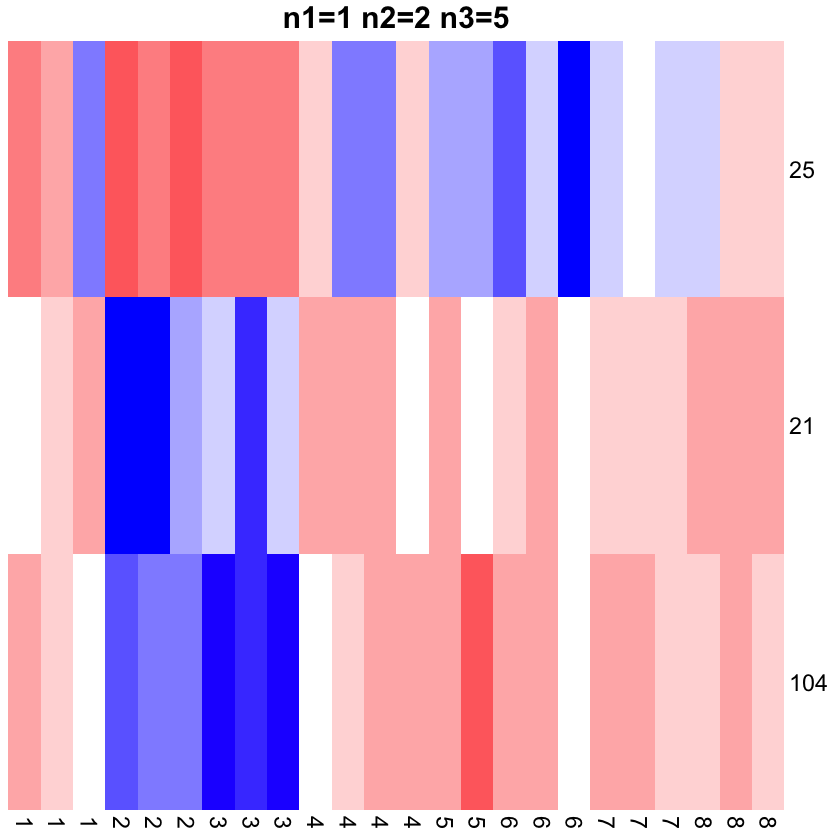

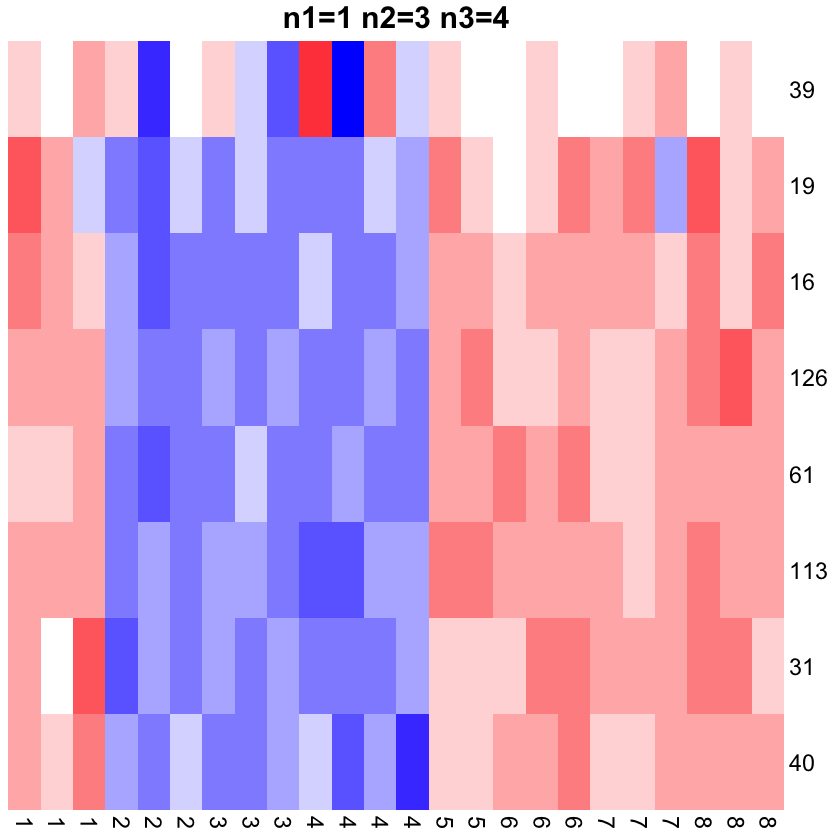

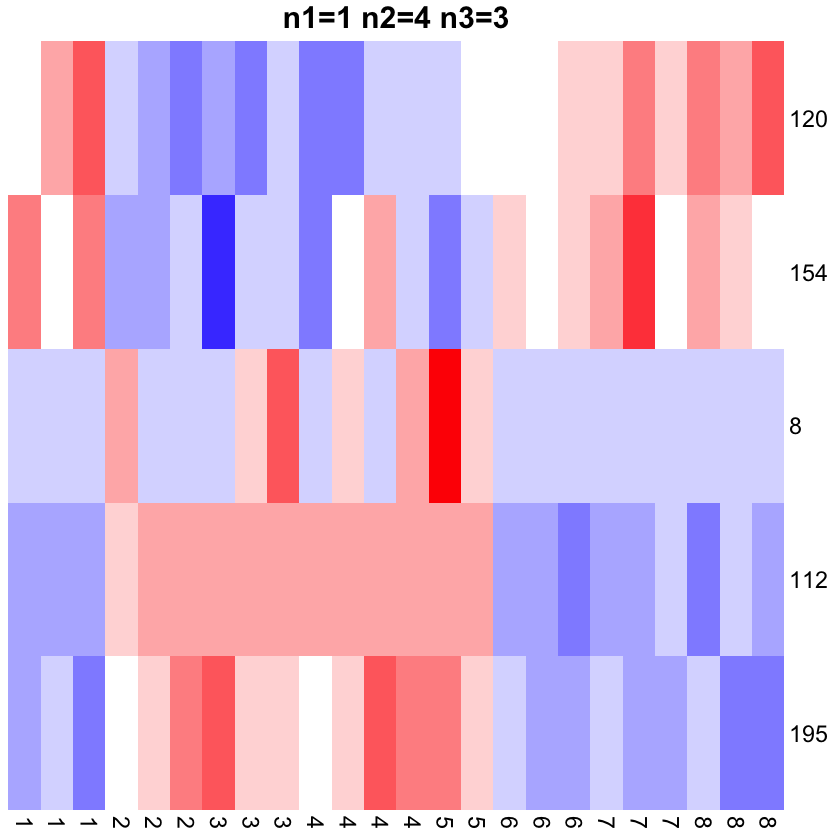

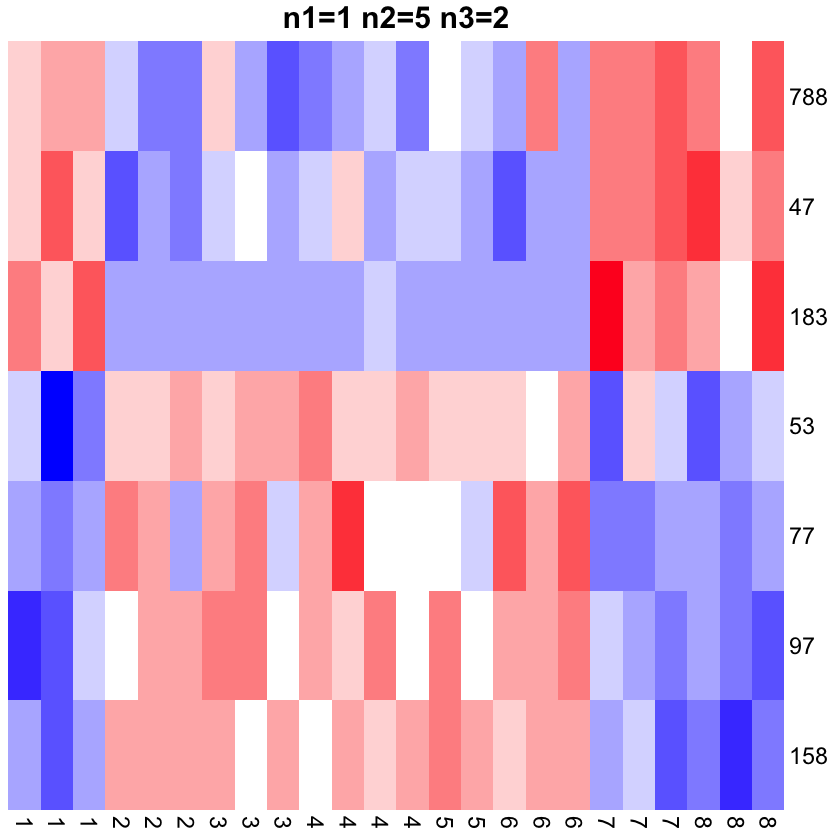

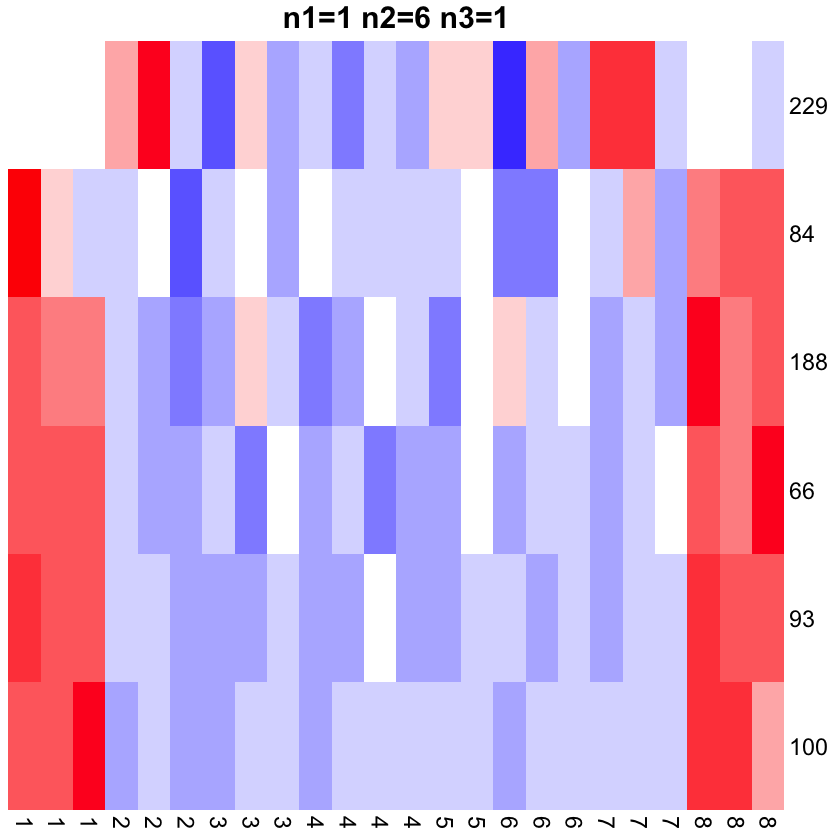

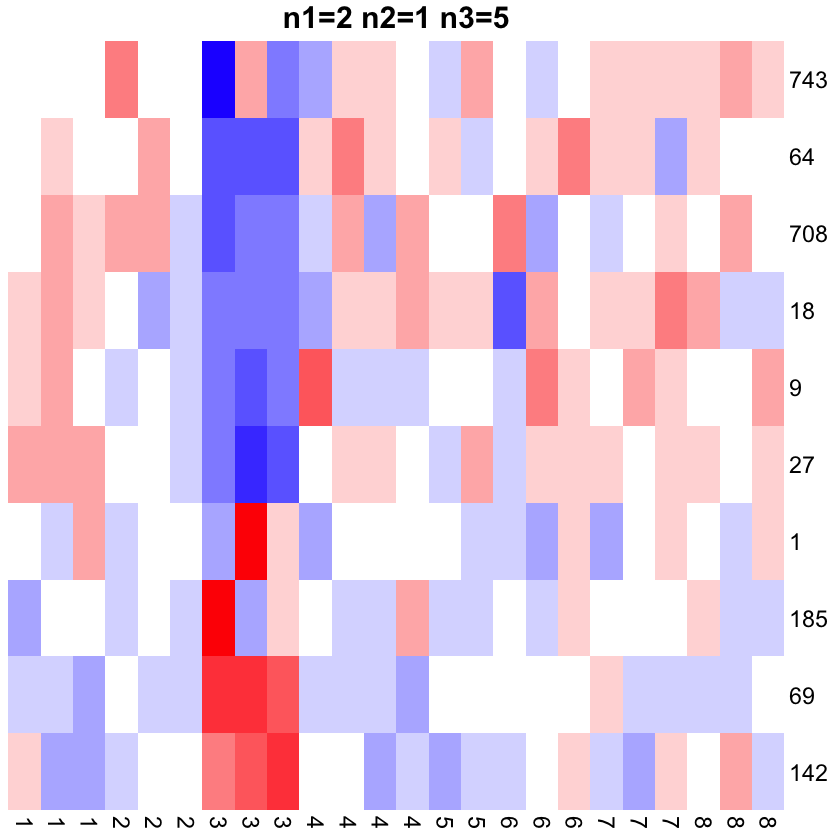

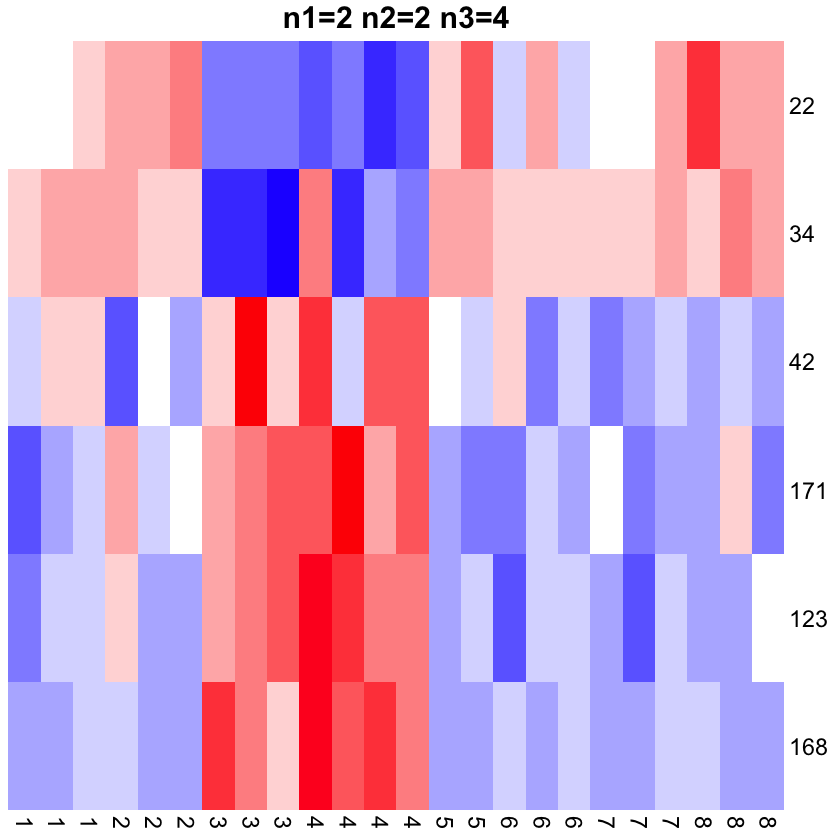

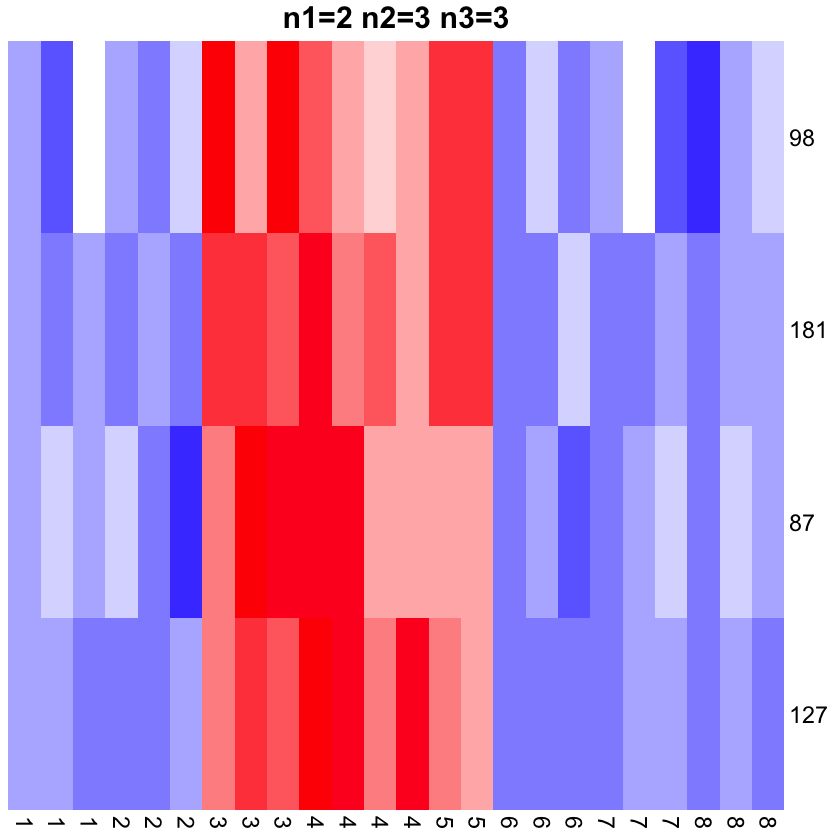

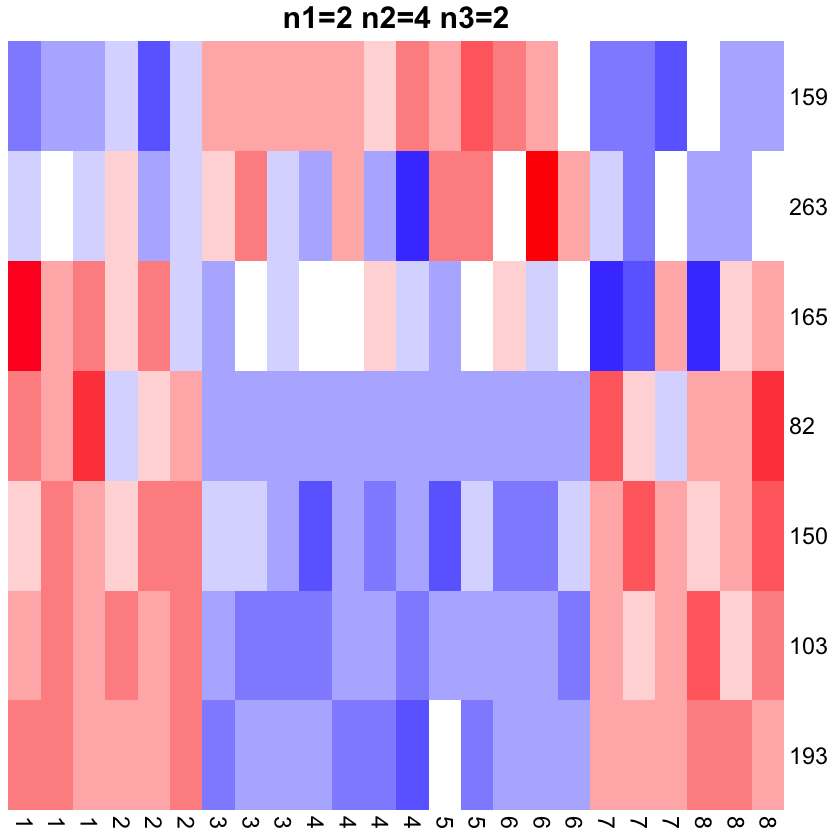

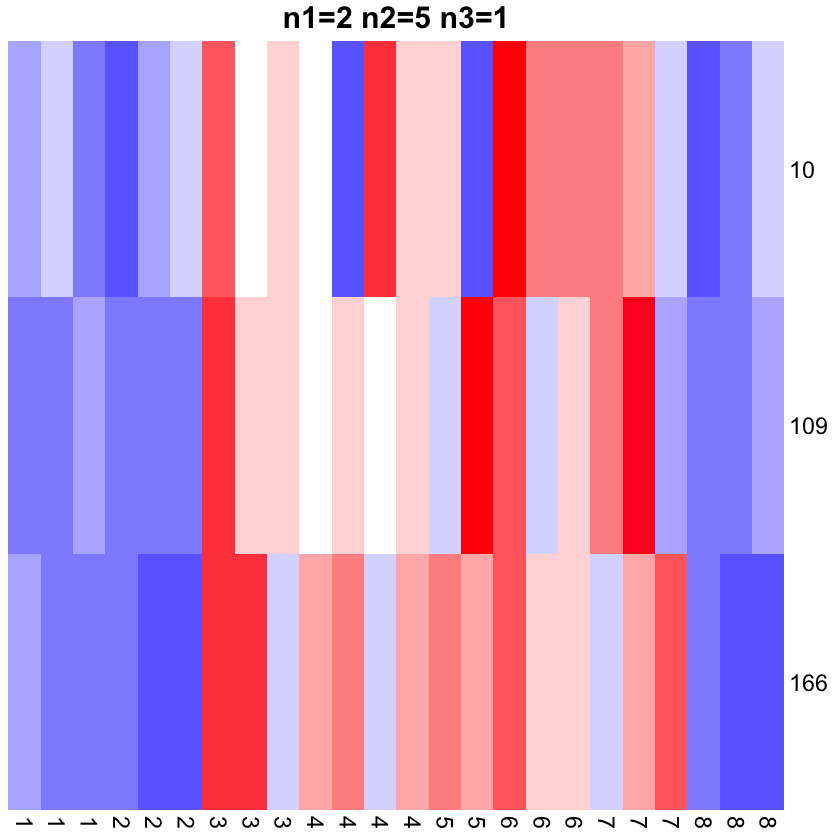

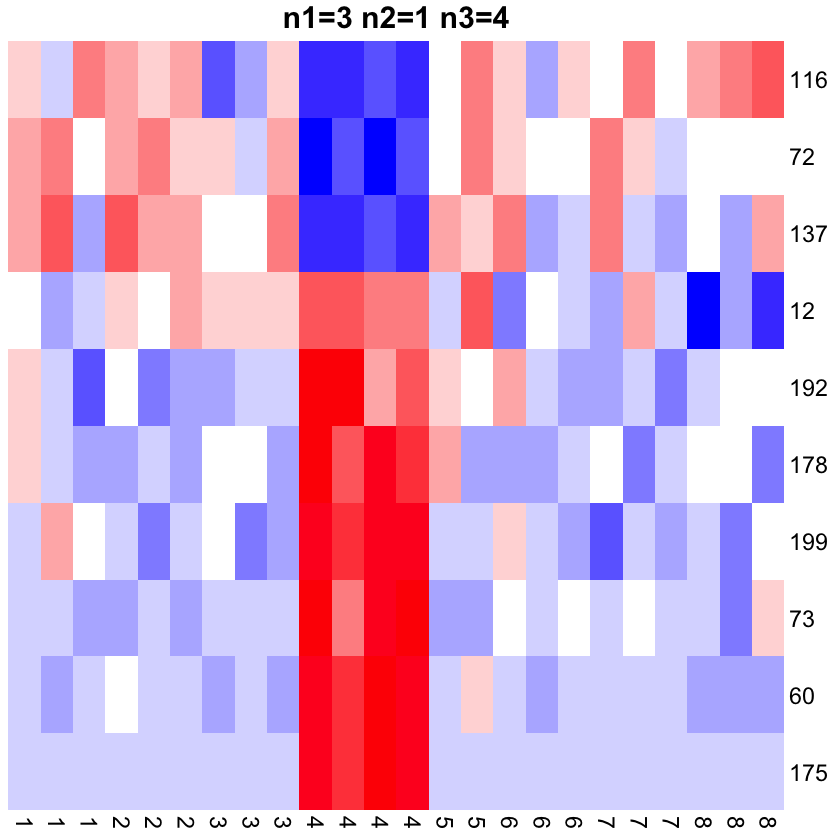

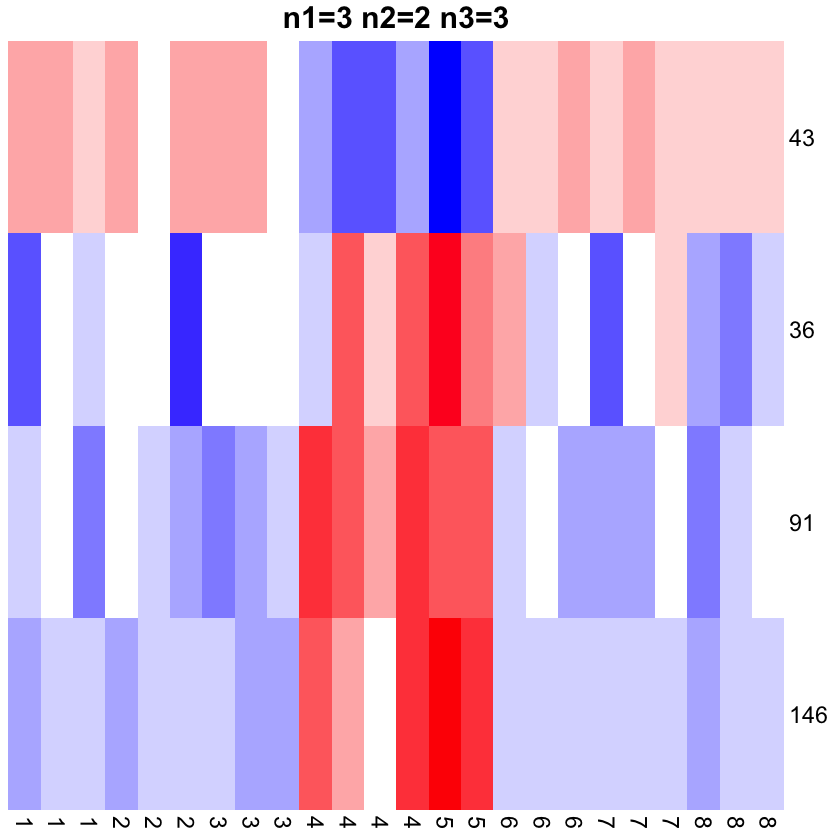

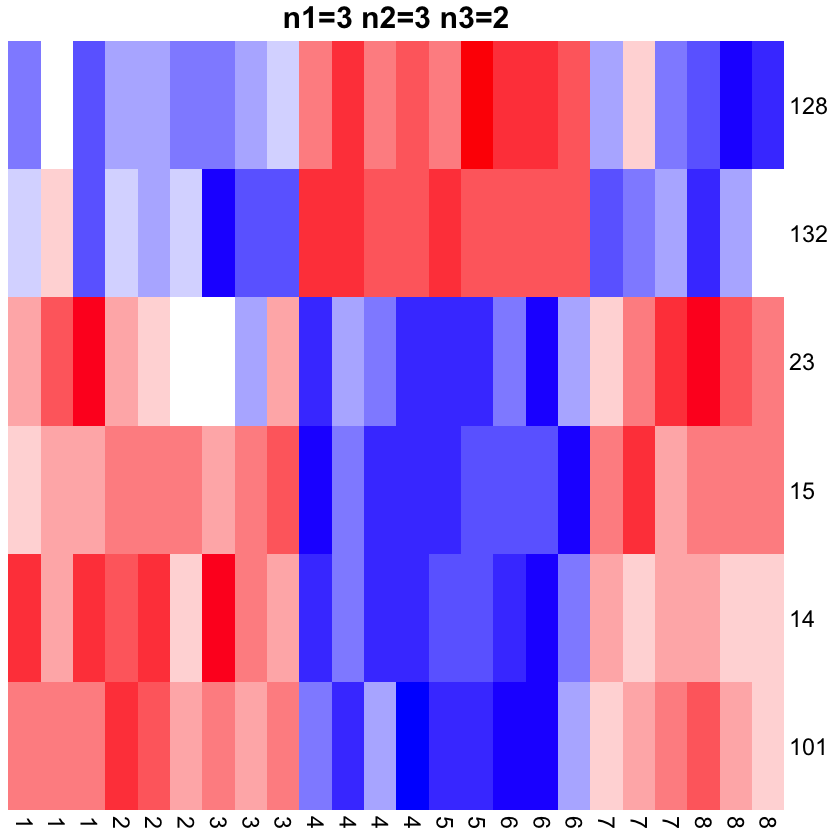

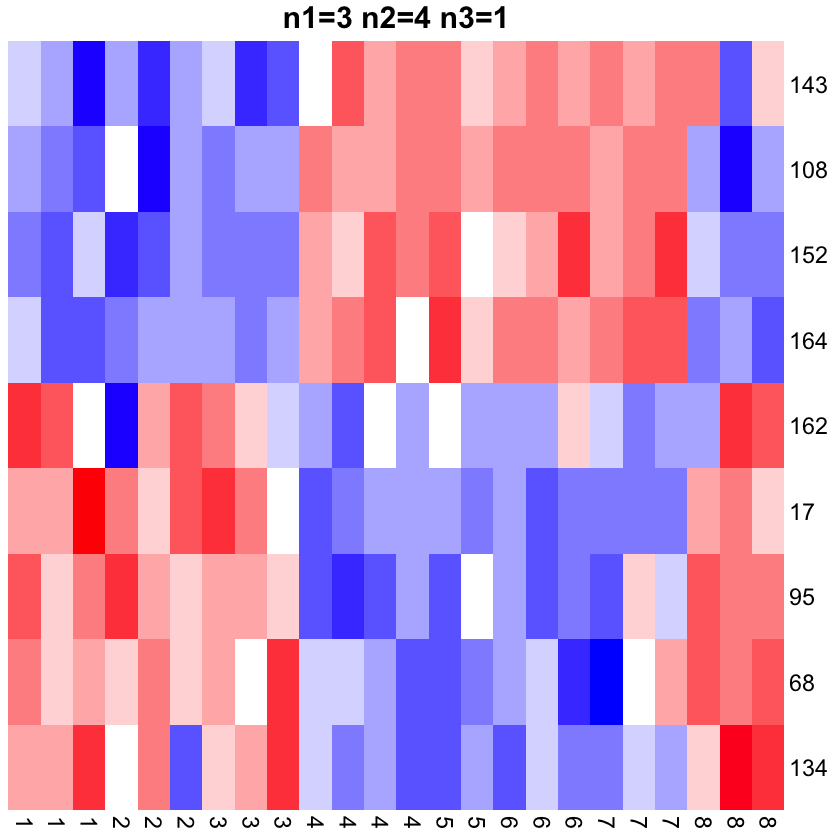

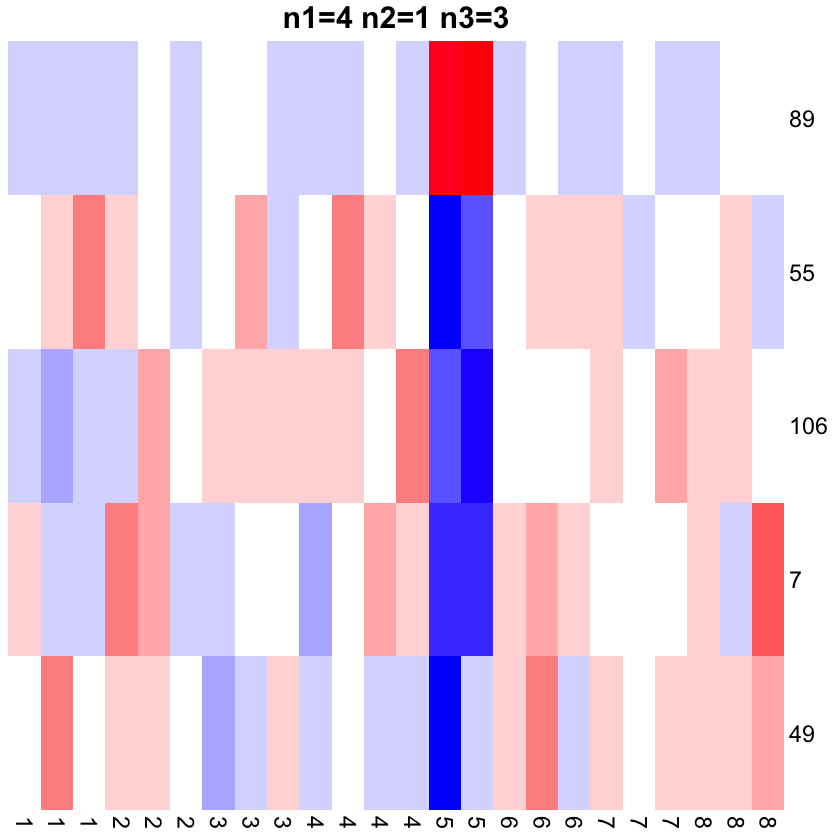

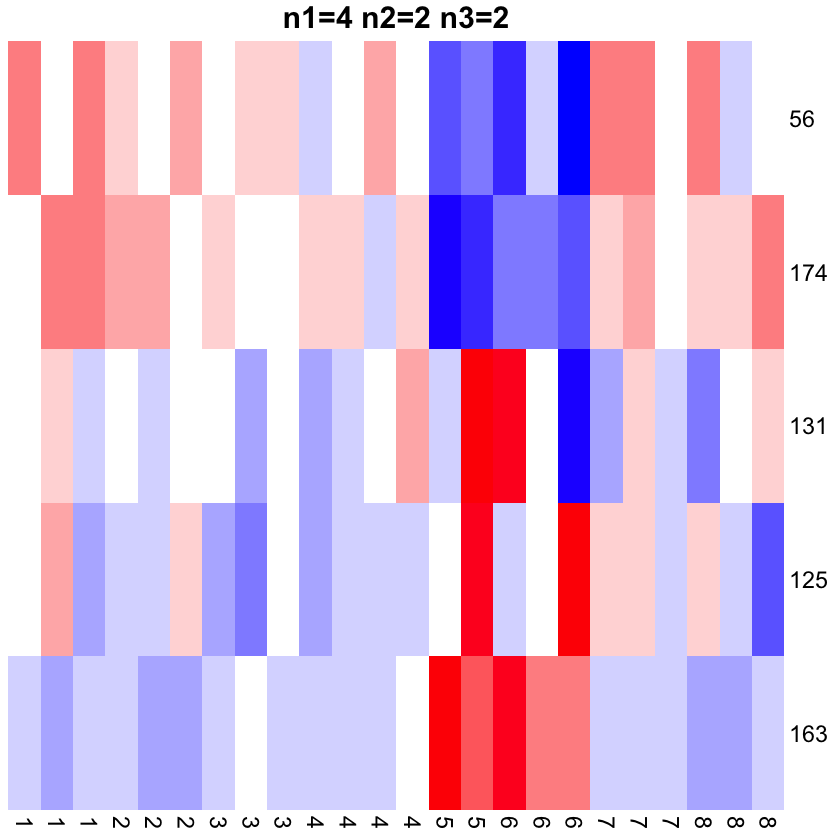

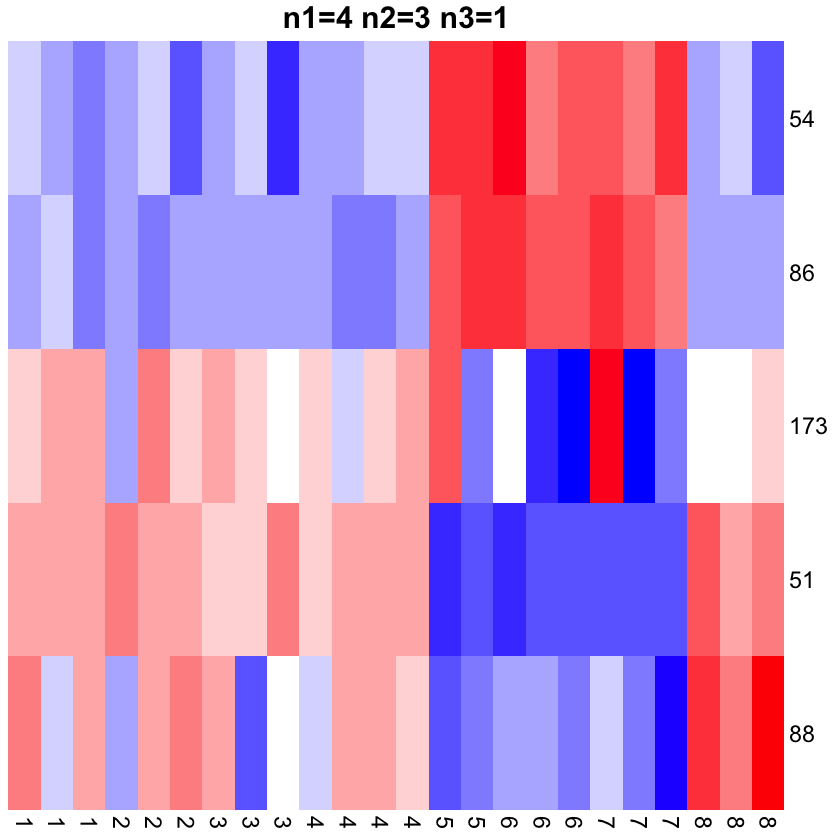

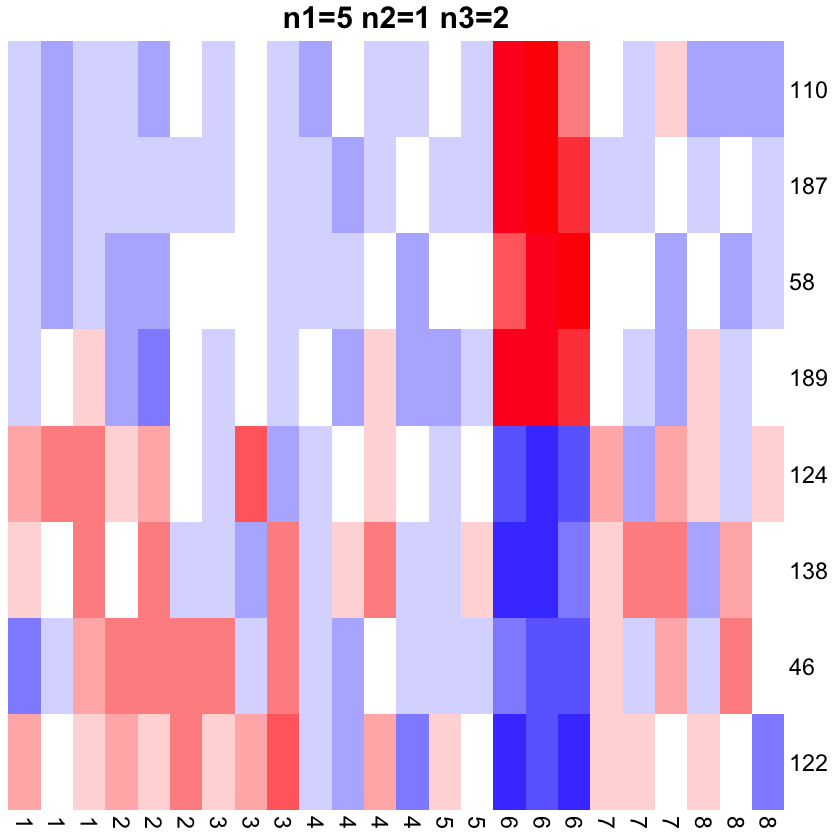

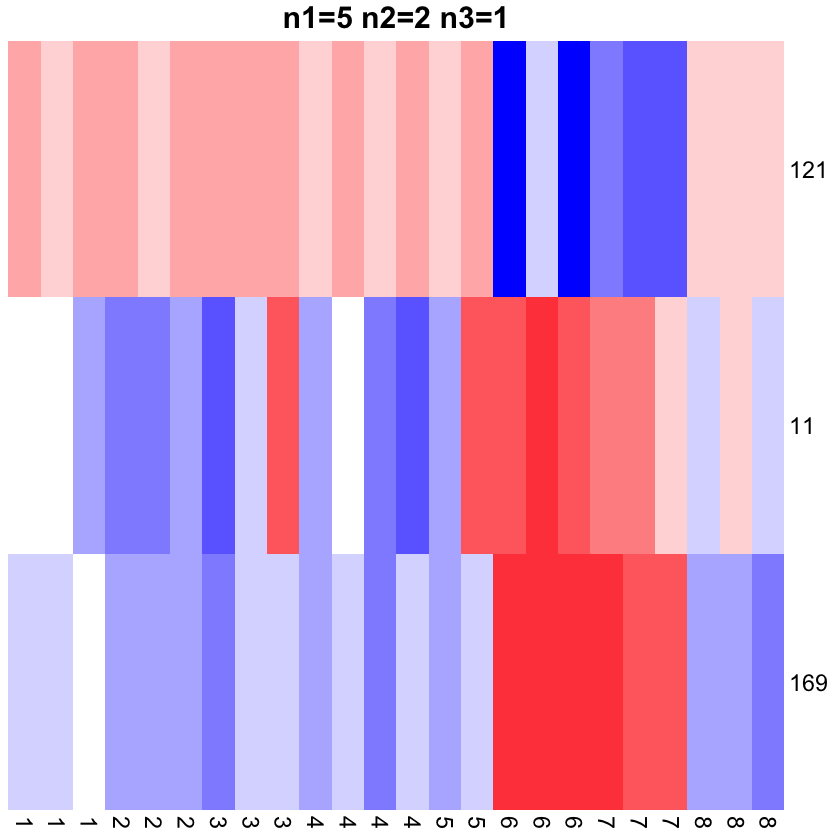

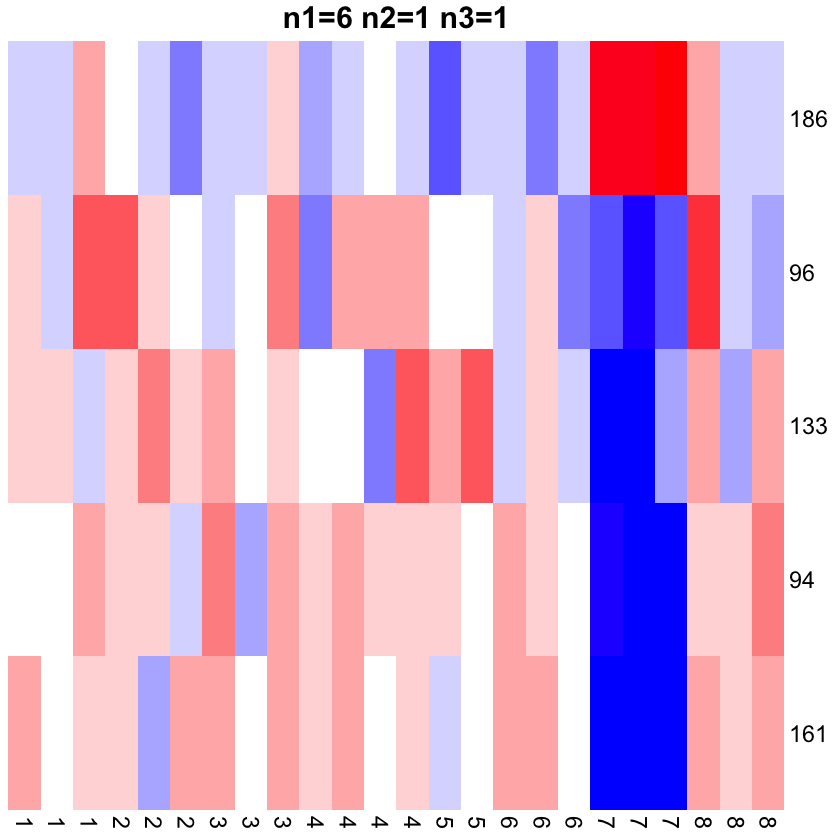

In [5]:
library(pheatmap)
cp.position = result$cp.position

for(i in 1:nrow(changePointTable)) {
  seqID = c()
  for(j in 1:nrow(cp.position)) {
    if(cp.position[j, "n1"]==changePointTable[i, "n1"] & cp.position[j, "n2"]==changePointTable[i, "n2"])
      seqID = c(seqID, cp.position[j, "SeqID"])
  }
  if(length(seqID)==0) next;
  h.data = matrix(gene.exp[seqID,], nrow=length(seqID))
  h.data = t(scale(t(h.data), center=T, scale=T))
  rownames(h.data) = rownames(gene.exp)[seqID]
  colnames(h.data) = rep(1:timePoint, times=replicate)
  h.scale = max(abs(max(h.data)), abs(min(h.data)))
  n1 = changePointTable[i, "n1"]
  n2 = changePointTable[i, "n2"]
  n3 = changePointTable[i, "n3"]
  
 
  pheatmap(h.data, clustering_distance_rows="correlation", clustering_distance_cols="correlation", clustering_method="complete",
     legend=F, treeheight_row=0, border_color=NA, fontsize=14,
     show_colnames=T, show_rownames=T, cluster_cols=F, cluster_rows=T,
     breaks=seq(from=-h.scale,to=h.scale,len=15+1), color = colorRampPalette(c("blue", "white", "red"))(15),
     main=paste("n1=",n1," n2=",n2," n3=",n3,sep=""))
}